In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns

In [109]:
C = "[4]carbamidomethyl[C]"
M = "[35]oxidation[M]"

def convert_mods(x):
    if str(x) == "nan":
        return ""
    tmp = x.split(',')
    buf = ""
    for t in tmp:
        tmp2 = t.split('(')
        pos = tmp2[0][:-1]
        if tmp2[0][-1] == "C":
            buf += pos + '|' + C + '|'
        if tmp2[0][-1] == "M":
            buf += pos + '|' + M + '|'
    return buf[:-1].replace(" ","")

def is_in_s(x):
    return x in s

# Data

I performed an open ionbot and msfragger search (oxididation of M variable, max 2 missed cleavages).

See SOP document for more details on how MSFragger was ran.

In [110]:
#set this your local folder as the data was pushed to the repo as well
folder = "/home/compomics/tools/ionbot_paper"
dataset = "PXD001468"

 # Results
 
Load ionbot PSM results (first-matches + coeluting matches + features) + protein results.

In [111]:

folder2 = folder + "/" + dataset
ionbot = pd.read_csv("%s/ionbot.first.csv"%folder2)
ionbot["rank"] = ["first"]*len(ionbot)
tmp = pd.read_csv("%s/ionbot.lower.csv"%folder2)
tmp["rank"] = ["lower"]*len(tmp)
ionbot = pd.concat([ionbot,tmp])
tmp = pd.read_csv("%s/ionbot.features.csv"%folder2)
ionbot = ionbot.merge(tmp,on="ionbot_match_id",how="left")

In [112]:
print(len(ionbot))
ionbot = ionbot[(ionbot["database"]=="T")&(ionbot["q-value"]<=0.01)]
print(len(ionbot))

1507944
743917


In [113]:
def contains_missed_cleavage(x):
    if "K" in x[:-1]:
        return True
    if "R" in x[:-1]:
        return True
    return False

print(len(ionbot))
ionbot["contains_missed_cleavage"] = ionbot["matched_peptide"].apply(contains_missed_cleavage)    
ionbot["num_passed"] = ionbot.groupby(["spectrum_title"])["spectrum_title"].transform("count")
print(ionbot["num_passed"].value_counts())
ionbot = ionbot[(ionbot["num_passed"]==1) |
        (ionbot["rank"]=="lower") |
        ((ionbot["num_passed"]>1) & (ionbot["rank"]=="first") & (ionbot["unexpected_modification"].isna()) & (ionbot["contains_missed_cleavage"]==False))]
print(len(ionbot))
#need to re-assign best_psm
best_psms = ionbot.sort_values("psm_score").drop_duplicates("spectrum_title", keep="last")
best_psm_ids = set(best_psms["ionbot_match_id"])
ionbot["rank"] = ionbot["ionbot_match_id"].apply(
    lambda x: "first" if x in best_psm_ids else "lower")

743917
1    670146
2     70690
3      2985
4        96
Name: num_passed, dtype: int64
734334


Filter for identified matches.

This reads the PSM results from the full MSFragger pipeline:

In [114]:
fragger = pd.read_csv("%s/msfragger/%s/noprotein/psm.tsv"%(folder,dataset),sep="\t")
len(fragger)

772186

In [115]:
def get_scan_msfragger(x):
    return int(x.split('.')[-2])
def get_spectrum_file_msfragger(x):
    return x.split('.')[0]
fragger["scan"] = fragger["Spectrum"].apply(get_scan_msfragger)
#sfile is used to filter on spectrum file
fragger["sfile"] = fragger["Spectrum"].apply(get_spectrum_file_msfragger)

In [116]:
def get_scan_ionbot(x):
    return int(x.split('.')[1])
def get_spectrum_file_ionbot(x):
    return x.split('.')[0]
ionbot["scan"] = ionbot["spectrum_title"].apply(get_scan_ionbot)
ionbot["sfile"] = ionbot["spectrum_title"].apply(get_spectrum_file_ionbot)

In [117]:
def replace_L_I(x):
    return x.replace("L","I")
ionbot["PSM"] = ionbot["scan"].astype(str) + ionbot["sfile"] + ionbot["database_peptide"].apply(replace_L_I)
fragger["PSM"] = fragger["scan"].astype(str) + fragger["sfile"] + fragger["Peptide"].apply(replace_L_I)

In [118]:
s1 = set(ionbot["PSM"])
s2 = set(fragger["PSM"])

print(len(s1.difference(s2)))
print(len(s1.intersection(s2)))
print(len(s2.difference(s1)))

126553
607781
164405


Now I want to compute the MS2PIP correlation and DeepLC retention error for the MSFragger matches that don't contain an unexpected modification (Delta Mass < 0.5Da>).

So I write a .peprec file:

In [119]:
def correct_peptide(x):
    return x.replace("U","A")

fragger["modifications"] = fragger["Assigned Modifications"].apply(convert_mods)
tmp = fragger[np.abs(fragger["Delta Mass"])<0.5][["Spectrum","modifications","Peptide","Charge"]]
tmp.columns = ["spec_id","modifications","peptide","charge"]
tmp["peptide"] = tmp["peptide"].apply(correct_peptide)
tmp.to_csv("%s_fragger_noprotein.peprec"%dataset,index=False,sep=" ")

In [120]:
#create file for Prosit
def apply_ox(x):
    if not "xidation" in x["modifications"]:
        return x["peptide"]
    buf = x["peptide"]    
    tm = x["modifications"].split('|')
    to_add = 0
    for i in range(0,len(tm),2):
        if "xidation" in tm[i+1]:
            id = int(tm[i]) + to_add
            buf = buf[:id] + "M(ox)" + buf[id+1:]
            to_add += 4
    return buf

tmp["modified_sequence"] = tmp.apply(apply_ox,axis=1)

In [121]:
tmp = tmp[["modified_sequence","charge"]]
tmp["collision_energy"] = [30]*len(tmp)
tmp["fragmentation"] = ["HCD"]*len(tmp)
tmp = tmp[["modified_sequence","collision_energy","charge","fragmentation"]]
tmp.columns = ["modified_sequence","collision_energy","precursor_charge","fragmentation"]
tmp.to_csv("%s_fragger_noprotein_prosit.csv"%dataset,index=False,sep=" ")

Then I run this .peprec file trough ionbot to get the statistics. The results are written to ionbot.csv.

I merge the statistics with the MSFragger results:

In [69]:
fragger_stats = pd.read_csv("%s/msfragger/%s/noprotein/ionbot.csv"%(folder,dataset))

def get_title(x):
    return int(x.split("scan=")[1][:-1])

def get_sfile(x):
    return x.split(".")[0].replace('"','')

fragger_stats["scan"] = fragger_stats["title"].apply(get_title)
fragger_stats["sfile"] = fragger_stats["title"].apply(get_sfile)

tmp = fragger_stats[["scan","sfile","corr","rt_diff_A"]]
fragger = fragger.merge(tmp,on=["scan","sfile"],how="left")

I create columns to indicat if a PSM is unique to a search engine:

In [70]:
s1 = set(ionbot["PSM"])
s2 = set(fragger["PSM"])

print(len(s1.difference(s2)))
print(len(s1.intersection(s2)))
print(len(s2.difference(s1)))

s = s2.difference(s1)
fragger["unique"] = fragger["PSM"].apply(is_in_s)
s = s1.difference(s2)
ionbot["unique"] = ionbot["PSM"].apply(is_in_s)

123966
605585
166601


I look at the MS2PIP correlation for the PSMs unqiue to each search engine:

<AxesSubplot:xlabel='type', ylabel='value'>

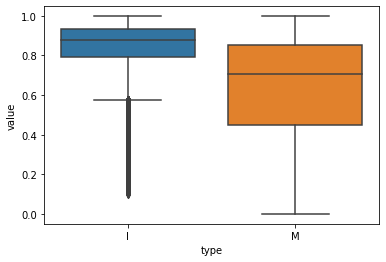

In [71]:
tmp = pd.DataFrame()
tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["by-intensity-pattern-correlation"]
tmp["type"] = ["I"]*len(tmp)
tmp2 = pd.DataFrame()
tmp2["value"] = fragger[(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)]["corr"]
tmp2["type"] = ["M"]*len(tmp2)
tmp = pd.concat([tmp,tmp2])
sns.boxplot(x="type",y="value",data=tmp)


In [72]:
fragger[(fragger["sfile"]=="b1906_293T_proteinID_01A_QE3_122212")&(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)&(fragger["corr"]<0.4)].to_csv("check.csv",index=False)

I look at the DeepLC retention error for the PSMs unqiue to each search engine:

<AxesSubplot:xlabel='type', ylabel='value'>

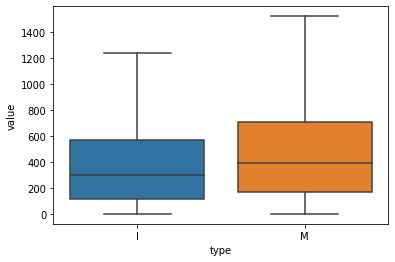

In [73]:
tmp = pd.DataFrame()
tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["rt-pred-error"]
tmp["type"] = ["I"]*len(tmp)
tmp2 = pd.DataFrame()
tmp2["value"] = fragger[(np.abs(fragger["Delta Mass"])<0.05)&(fragger["unique"]==True)]["rt_diff_A"]
tmp2["type"] = ["M"]*len(tmp2)
tmp = pd.concat([tmp,tmp2])
sns.boxplot(x="type",y="value",data=tmp, showfliers=False)

Next I read the results from the MSFragger Percolator pipeline (see SOP).

I do this by merging the Percolator results with the .tsv results files written by MSFragger as well.

In [74]:
#read all tsv files into DataFrame
datasets = ionbot["sfile"].unique()
X = []
for ds in datasets:
    d = pd.read_csv("%s/msfragger/%s/%s.tsv"%(folder,dataset,ds),sep="\t")
    d["sfile"] = [ds]*len(d)
    X.append(d)

fragger_perc = pd.concat(X)
fragger_perc.rename(columns={'scannum':'scan'}, inplace=True)


Thes result files contain decoy hits, so I filter these:

In [75]:
def is_decoy(x):
    return "decoy_" in x
fragger_perc["is_decoy"] = fragger_perc["protein"].apply(is_decoy)

Next I read the FDR statistics obtained by running percolator in the merged pin file (SOP).

The following reads the Percolator results. For some PSMs Percolator does not return statistics. I set these to 1.

In [76]:
#add statistics
X = []
with open("%s/msfragger/%s/o"%(folder,dataset)) as f:
    f.readline()
    for row in f:
        l = row.rstrip().split('\t')
        sfile = l[0].split('.')[0]
        scan = int(l[0].split('.')[-2])
        X.append([scan,sfile,float(l[2]),float(l[3])])
stats = pd.DataFrame(X,columns=["scan","sfile","q-value","PEP"])
fragger_perc = fragger_perc.merge(stats,on=["scan","sfile"],how="left")
fragger_perc["q-value"].fillna(1,inplace=True)
fragger_perc["PEP"].fillna(1,inplace=True)

In [77]:
fragger_perc = fragger_perc[(fragger_perc["is_decoy"]==False)&(fragger_perc["q-value"]<0.01)]

As I can run Crystal-C only on pepXML files I need to correct the peptides and massdiff (SOP).

For this I use the full pipeline results (that includes Crystal-C) and then map these corrected matches back.

In [78]:
tmp = fragger[["scan","sfile","Peptide","Delta Mass"]]
fragger_perc = fragger_perc.merge(tmp,on=["scan","sfile"],how="left")

For some PSMs there are missing PSMs in the full results:

In [79]:
fragger_perc[["Peptide","Delta Mass"]].isna().sum()

Peptide       13035
Delta Mass    13035
dtype: int64

So I copy the original values into the missing values.

In [80]:
fragger_perc['Peptide'] = fragger_perc.apply(
    lambda row: row['peptide'] if pd.isnull(row['Peptide']) else row['Peptide'],
    axis=1
)
fragger_perc['Delta Mass'] = fragger_perc.apply(
    lambda row: row['massdiff'] if np.isnan(row['Delta Mass']) else row['Delta Mass'],
    axis=1
)

This is the PSM overlap for the Percolator version of MSFragger:

In [81]:
fragger_perc["PSM"] = fragger_perc["scan"].astype(str) + fragger_perc["sfile"] + fragger_perc["Peptide"].apply(replace_L_I)
s1 = set(ionbot["PSM"])
s2 = set(fragger_perc["PSM"])

print(len(s1.difference(s2)))
print(len(s1.intersection(s2)))
print(len(s2.difference(s1)))

168457
561094
123865


Next I create .peprec files to run ionbot on these MSFragger PSMs.

In [82]:
tmp = fragger[["scan","sfile","Spectrum"]]
fragger_perc = fragger_perc.merge(tmp,on=["scan","sfile"],how="left")

Issue here is that there are still missing titles:

In [83]:
fragger_perc[["Spectrum"]].isna().sum()

Spectrum    13035
dtype: int64

So I have to construct these:

In [84]:
def construct_title(x):
    return x["sfile"] + '.' + str(x["scan"]).zfill(5) + '.' + str(x["scan"]).zfill(5) + '.' + str(x["charge"])

def correct_title_for_mgf(x):
    tmp = x.split('.')
    return tmp[0] + '.' + tmp[1].lstrip("0") + '.' + tmp[1].lstrip("0") + '.' + tmp[3]

fragger_perc["spectrum_title"] = fragger_perc.apply(construct_title,axis=1) 
#there are still issues with charges that have been recalibrated
#note that these are not recallibrated in ionbot
#I need the original title to make it correspond to the spectrum file title (short version -> need to adjust ionbot code temporarily)
fragger_perc['spectrum_title'] = fragger_perc.apply(
    lambda row: row['Spectrum'] if (row['Spectrum'] != row["spectrum_title"]) & (pd.isna(row['Spectrum'])==False) else row['spectrum_title'],
    axis=1
)
fragger_perc["spectrum_title"] = fragger_perc["spectrum_title"].apply(correct_title_for_mgf)

I write the .peprec file for ionbot:

In [85]:
#Now I have everyting needed to write the .peprec file
#First I filter for matches without unexpected mod (abs(Delta Mass) < 0.05)
to_write = fragger_perc[np.abs(fragger_perc["Delta Mass"])<0.05]
print(len(to_write))

#Then I convert modifications

to_write["modifications"] = to_write["modification_info"].apply(convert_mods)

to_write = to_write[["spectrum_title","modifications","Peptide","charge"]]
to_write.columns = ["spec_id","modifications","peptide","charge"]
to_write.to_csv("%s.peprec"%dataset,sep=" ",index=False)

506611


/tmp/ipykernel_2167249/1188285847.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_write["modifications"] = to_write["modification_info"].apply(convert_mods)


I read the ionbot results and merge the MS2PIP correlation and LC retention time error with the MSFragger results:

In [86]:
fragger_stats = pd.read_csv("%s/msfragger/%s/ionbot.csv"%(folder,dataset))

def get_title(x):
    return int(x.split("scan=")[1][:-1])

def get_sfile(x):
    return x.split(".")[0]

fragger_stats["scan"] = fragger_stats["title"].apply(get_title)
fragger_stats["sfile"] = fragger_stats["title"].apply(get_sfile)

tmp = fragger_stats[["scan","sfile","corr","rt_diff_A"]]
fragger_perc = fragger_perc.merge(tmp,on=["scan","sfile"],how="left")

This is the PSM overlap:

In [87]:
s1 = set(ionbot["PSM"])
s2 = set(fragger_perc["PSM"])

print(len(s1.difference(s2)))
print(len(s1.intersection(s2)))
print(len(s2.difference(s1)))


168457
561094
123865


Let's look at the PSM properties for each of the sections again:

In [88]:
s = set(s2.difference(s1))
fragger_perc["unique"] = fragger_perc["PSM"].apply(is_in_s)
s = set(s1.difference(s2))
ionbot["unique"] = ionbot["PSM"].apply(is_in_s)
s = set(s1.intersection(s2))
ionbot["intersection"] = ionbot["PSM"].apply(is_in_s)

<AxesSubplot:xlabel='type', ylabel='value'>

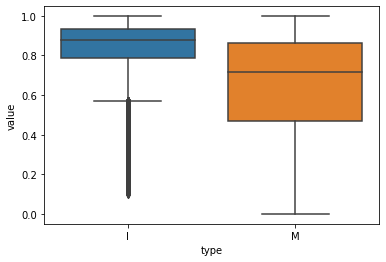

In [89]:
tmp = pd.DataFrame()
tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["by-intensity-pattern-correlation"]
tmp["type"] = ["I"]*len(tmp)
tmp2 = pd.DataFrame()
tmp2["value"] = fragger_perc[(np.abs(fragger_perc["massdiff"])<0.05)&(fragger_perc["unique"]==True)]["corr"]
tmp2["type"] = ["M"]*len(tmp2)
tmp = pd.concat([tmp,tmp2])
sns.boxplot(x="type",y="value",data=tmp)

<AxesSubplot:xlabel='type', ylabel='value'>

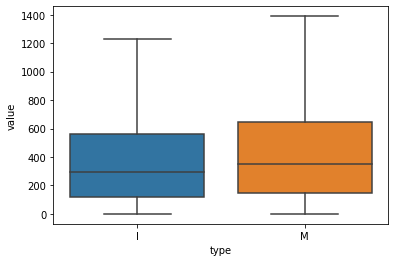

In [90]:
tmp = pd.DataFrame()
tmp["value"] = ionbot[(ionbot["unexpected_modification"].isna())&(ionbot["unique"]==True)]["rt-pred-error"]
tmp["type"] = ["I"]*len(tmp)
tmp2 = pd.DataFrame()
tmp2["value"] = fragger_perc[(np.abs(fragger_perc["massdiff"])<0.05)&(fragger_perc["unique"]==True)]["rt_diff_A"]
tmp2["type"] = ["M"]*len(tmp2)
tmp = pd.concat([tmp,tmp2])
sns.boxplot(x="type",y="value",data=tmp, showfliers=False)